## Задание:
Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно. Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 
1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [5]:
# Импортируем необходимые библиотеки

import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [6]:
# Подключаемся к БД

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [7]:
# Делаем запрос необходимых данных 
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [8]:
# Проверим количество пользователей в каждой группе
df.groupby('exp_group').user_id.count()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

Группы получились примерно одинаковые как и ожидалось

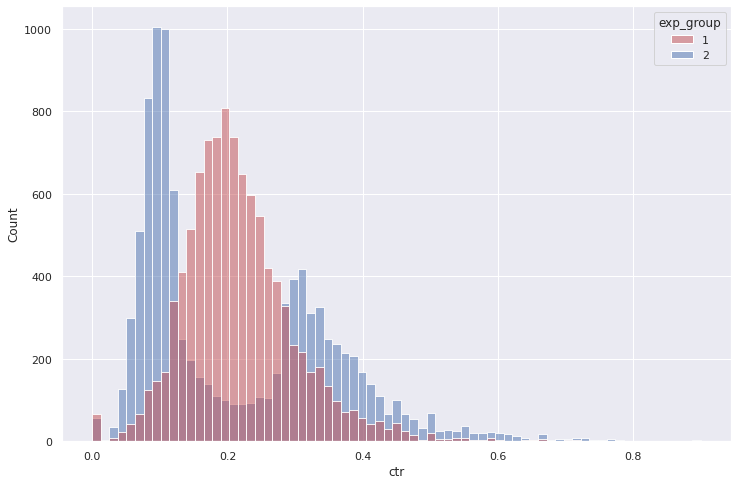

In [9]:
# Построим график, чтобы посмотреть на наши данные
sns.set(rc={'figure.figsize':(12, 8)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Распределение CTR в перовой группе похоже на нормальное, что нельзя сказать о распределении CTR во второй группе.
Мы видим, что CTR в данных группах отличается.

## Проводим t-тест

In [10]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

T-тест показал, что нет статистически значимых различий.
Возможно это связано с тем, что распределение CTR во второй группе не является нормальным.

## Проводим тест Манна-Уитни

In [11]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [12]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 55.98 % случаев A > B. Должно получиться около 50%


Тест Манна-Уитни показал, что статистически значимые различия есть. 
При этом в первой группе (контроль) CTR больше, чем во второй.

## Cглаженный CTR

In [13]:
# Создаем функцию для расчета сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [14]:
# Считаем общегрупповой CTR для каждой группы
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [15]:
# Считаем сглаженный CTR для первой группы
group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [16]:
# Считаем сглаженный CTR для второй группы
group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr'>

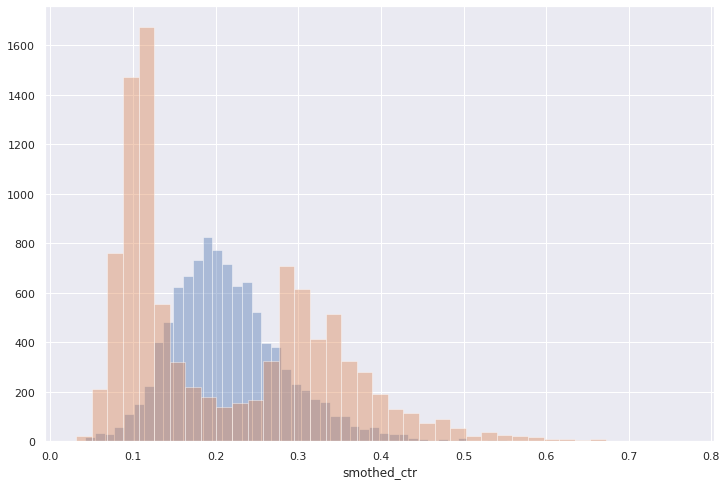

In [18]:
# Строим распределения сглаженного CTR для двух групп
sns.distplot(group1.smothed_ctr, 
             kde = False)
sns.distplot(group2.smothed_ctr, 
             kde = False)

График также показал, что распределение для первой группы похоже на нормальное, а для второй нет. 
А также, что имеется разница.

In [19]:
# Проводим t-тест на сглаженных CTR 
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027678, pvalue=0.05166679015318533)

In [20]:
# Проводим тест Манна-Уитни на сглаженном CTR
stats.mannwhitneyu(group1.smothed_ctr,
                   group2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55528353.0, pvalue=2.396534039374286e-50)

In [29]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= group1.smothed_ctr.sample().values[0] > group2.smothed_ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 55.47 % случаев A > B. Должно получиться около 50%


Значение p-value в t-тесте получилось значительно меньше (немного больше уровня значимости 0.05). 
Таким образом, можно сказать, что результ не является статистически значимыми и мы не можем отклонить нулевую гипотезу.
Тест Манна-Уитни показал, что статистически значимые различия есть. При этом в первой группе (контроль) CTR больше, чем во второй.
Однозначно сделать вывод на тестах сглаженного CTR не получается.

## Пуассоновский бутстреп для подсчета разницы в CTR

In [21]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (2000, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (2000, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [22]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [23]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

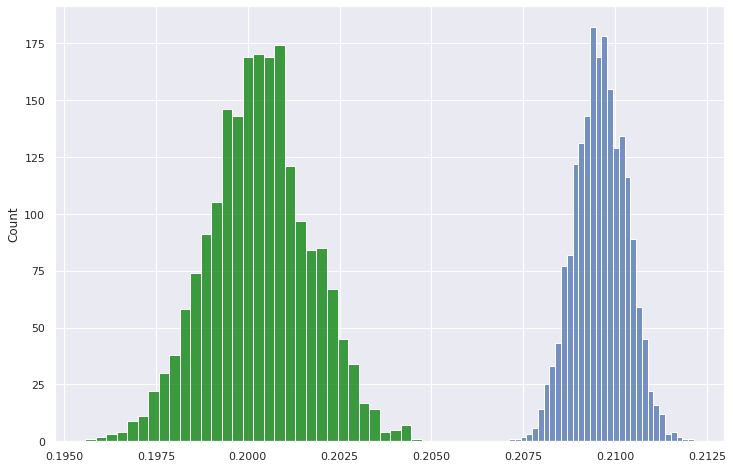

In [25]:
sns.histplot(ctr1)
sns.histplot(ctr2, color='green')

<AxesSubplot:ylabel='Count'>

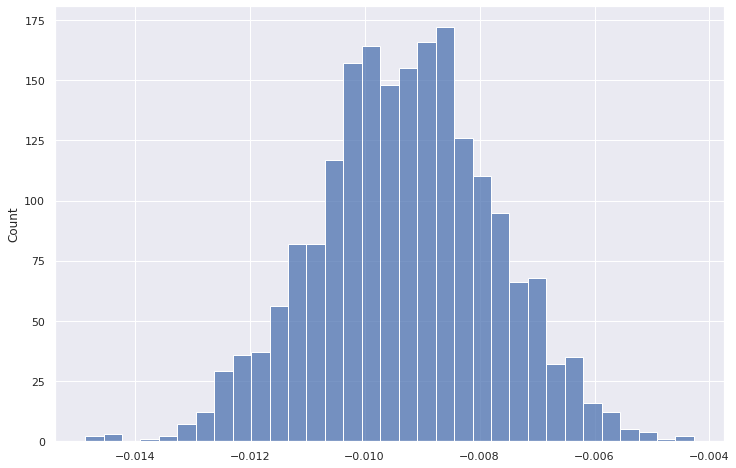

In [26]:
# Распределение разницы между "глобальными CTR"
sns.histplot(ctr2 - ctr1)

Разница между глобальными CTR в данных группах получилась отрицательной.
Пуассоновский бутстреп показал разницу в групповых CTR. При этом во второй группе оказался CTR меньше, чем в первой.
Распределения глобальных CTR получились схожими с нормальным, и видно на сколько сильно они отличаются (даже не пересекаются). 
В Пуасоновсом бутстрепе благодаря достаточному количеству пользователей удалось сгенерировать репрезентативные выборки.

## Бакетное преобразование

In [41]:
# Делаем запрос необходимых данных и генерируем бакеты
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-06-30' and '2023-07-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

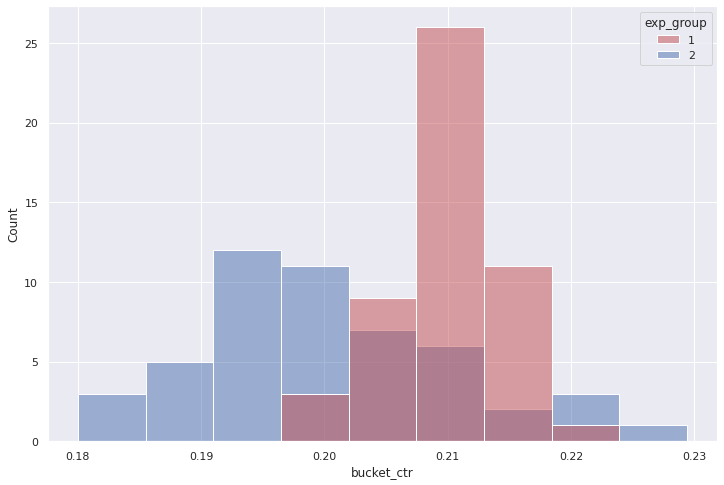

In [37]:
sns.histplot(data = df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Видим,что распределения чем-то похоже на нормальные.

In [42]:
# Проведем t-тест поверх бакетного преобразования
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

Здесь t-тест показал,что есть статистически значимые различия

In [45]:
# Проведем тест Манна-Уитни поверх бакетного преобразования
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [44]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df_bucket[df_bucket.exp_group == 1].bucket_ctr.sample().values[0] > df_bucket[df_bucket.exp_group == 2].bucket_ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 80.41 % случаев A > B. Должно получиться около 50%


In [ ]:
И тест Манна-Уитни тоже показал статистически значимые различия

## Вывод: 
Анализ результатов A/B тестов данными методами показал различные результаты. 
T-тест практически во всех случаях отрицал различия, скорее это связано с тем, что распределение CTR во второй группе было совсем не похоже на нормальное.
Тест Манна-Уитни напротив говорил, что статистически значимые различая есть, при этом CTR в первой (контрольной) группе был выше, чем во второй. 
В связи с этим эксперимент можно считать неудавшимся. Раскатывать новый алгоритм на всех новых пользователей не рекомендую.